In [1]:
import sys
!{sys.executable} -m pip install xgboost
import pandas as pd 
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
flights = pd.read_csv('flights.csv')
airlines = pd.read_csv('airlines.csv')
airports = pd.read_csv('airports.csv')

C:\Users\cdzek\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
flights.head(5)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [5]:
airlines.head(5)

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [6]:
airports.head(5)

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


### Solution steps
1. EDA
    - Data cleaning (Missing data, Outliers, data format)
    - Univariate analysis (Bar charts, Histograms)
    - Correlation Analysis (Line plots, scatter plots, heat map)
2. Feature Engineering
    - Numerical encoding
3. Feature selection
    - PCA
    - L1 regularization
4. Training the model
    - Model: XGBoost
    - Hyperparameter tuning (Depth, Min sample split, Random search)
5. Model evaluation
    - k-fold cross validation
    - MAE
6. Feature importance

#### Data cleaning

#### Missing data observed
Since there are missing data in the datset, I will use a machine learning model that is prone to missing data which is XGBoost model.

#### Feature Selection
Before visualizing the different features, I will first perform feature selection since all the features won't be used

In [3]:
# variables to remove
variables_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK', 'AIR_SYSTEM_DELAY',  'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']

In [4]:
flights.drop(variables_remove, axis = 1, inplace = True)

In [5]:
df = flights[['AIRLINE', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]

In [82]:
df.head()

,AIRLINE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,5,2354.0,-11.0,430,408.0,-22.0,205.0,194.0
1,AA,10,2.0,-8.0,750,741.0,-9.0,280.0,279.0
2,US,20,18.0,-2.0,806,811.0,5.0,286.0,293.0
3,AA,20,15.0,-5.0,805,756.0,-9.0,285.0,281.0
4,AS,25,24.0,-1.0,320,259.0,-21.0,235.0,215.0


In [55]:
# check null values

def check_null_values(df):
    flag=df.isna().sum().any()
    if flag==True:
        total = df.isnull().sum()
        percent = (df.isnull().sum())/(df.isnull().count()*100)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        for col in df.columns:
            dtype = str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)

In [56]:
check_null_values(df)

,AIRLINE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
Total,0,0,86153,86153,0,92513,105071,6,105071
Percent,0.0,0.0,0.000148,0.000148,0.0,0.000159,0.000181,0.0,0.000181
Types,object,int64,float64,float64,int64,float64,float64,float64,float64


### Outliers
Separating numerical and categorical features

In [83]:

num_cols = [i for i in df.columns if df[i].dtype in ['int', 'float']]
cat_cols = [i for i in df.columns if df[i].dtype == 'object']

print('Number of numerical columns:', len(num_cols))
print('Number of categorical columns:', len(cat_cols))

Number of numerical columns: 6
Number of categorical columns: 1


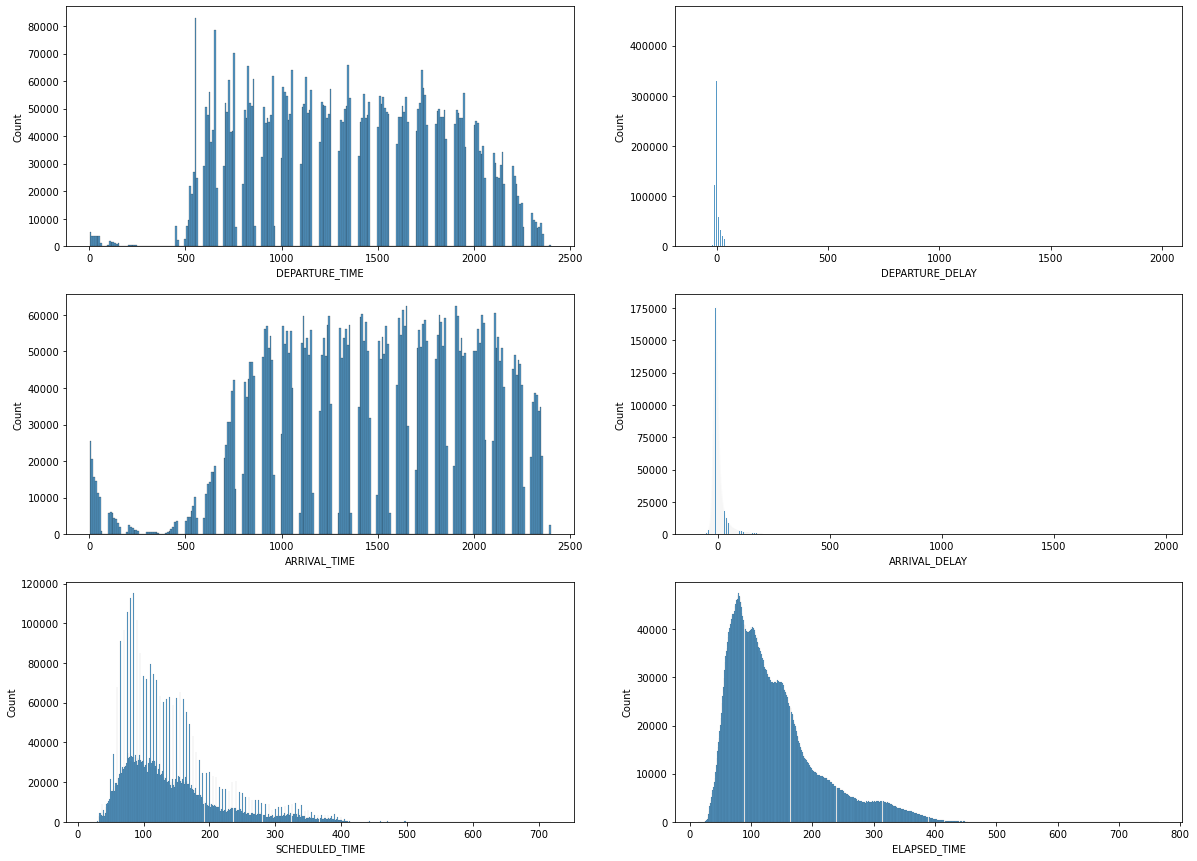

In [14]:
fig, ax = plt.subplots(3, 2, figsize = (20, 15))
c = 0
for i in range(3):
    for j in range(2):
        if c == 6:
            break
        sns.histplot(x = df[num_cols[c]], ax = ax[i, j])
        c += 1
plt.show()

In [15]:
airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [16]:
abbr_companies = airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [17]:
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)
df2.head()

,AIRLINE,DEPARTURE_DELAY
0,Alaska Airlines Inc.,-11.0
1,American Airlines Inc.,-8.0
2,US Airways Inc.,-2.0
3,American Airlines Inc.,-5.0
4,Alaska Airlines Inc.,-1.0


In [65]:
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']

<ipython-input-66-06792238d0e5>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])


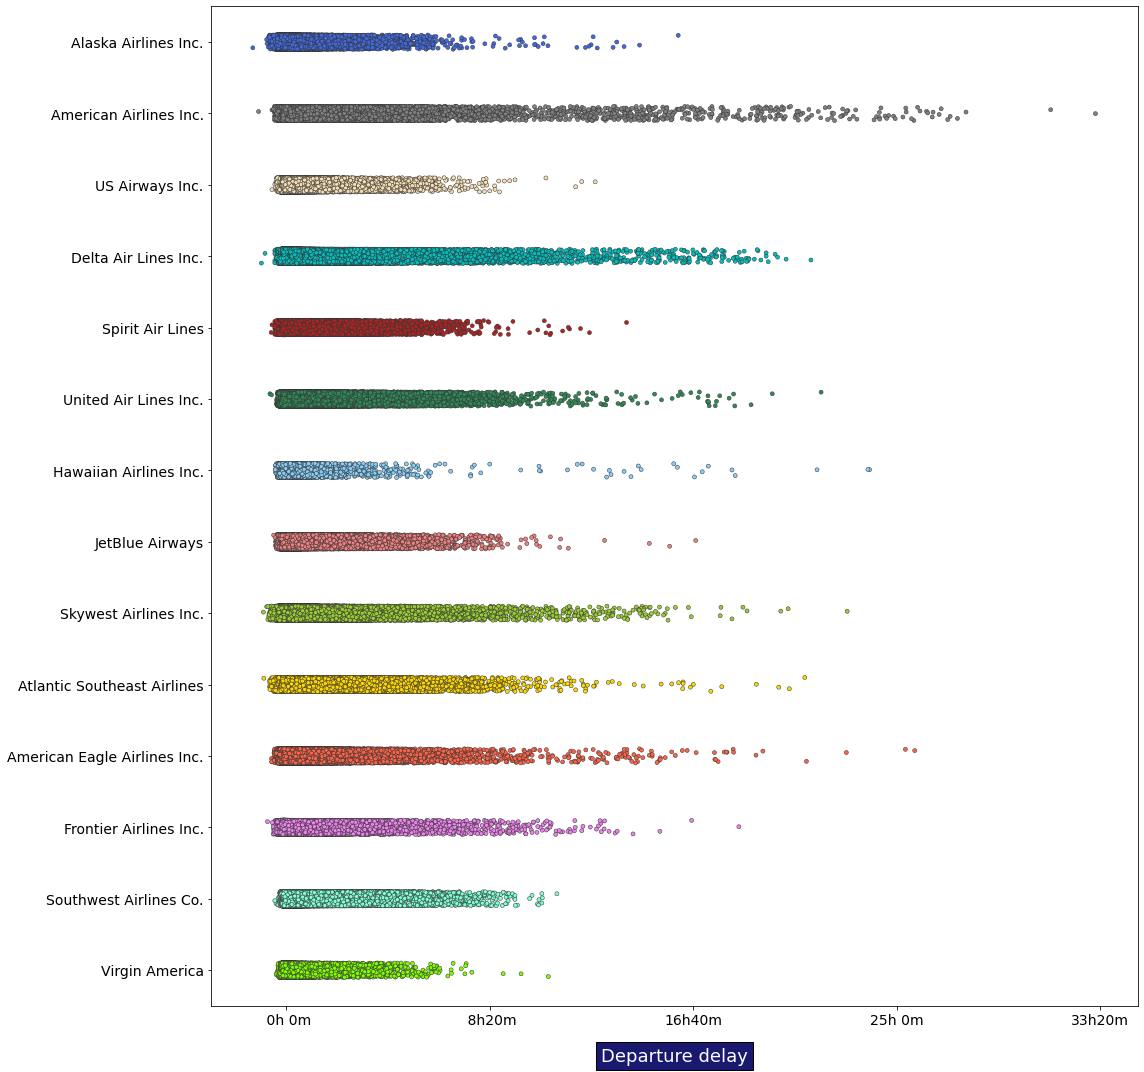

In [66]:
fig = plt.figure(1, figsize=(16,15))
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3)

In [6]:
delay_type = lambda x:((0,1)[x > 5])
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)

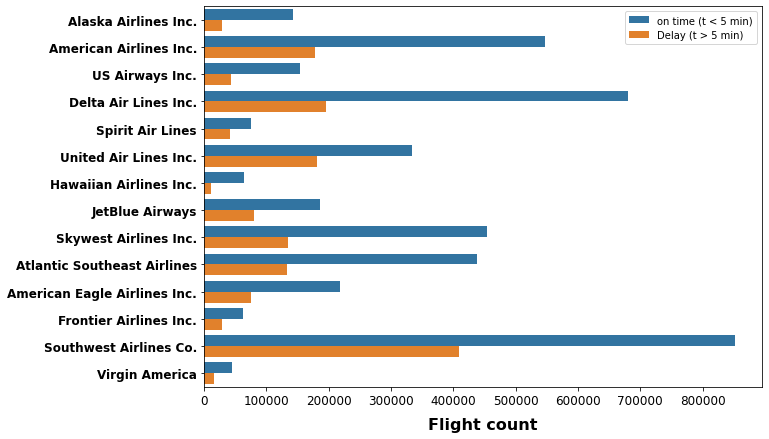

In [67]:
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('Delay (t > 5 min)')
plt.show()

observations

In [7]:
df = df.head(150000)

In [8]:
df.fillna(df.mean(),inplace=True)

In [22]:
n = len(pd.unique(df['AIRLINE']))
  
print("No.of.unique values of airline :", 
      n)

No.of.unique values of airline : 14


In [9]:
# performing one-hot-encoding on the categorical variable airline
df = pd.get_dummies(df, columns = ['AIRLINE'])

In [10]:
df.head()

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DELAY_LEVEL,AIRLINE_AA,...,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN
0,5,2354.0,-11.0,430,408.0,-22.0,205.0,194.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10,2.0,-8.0,750,741.0,-9.0,280.0,279.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,20,18.0,-2.0,806,811.0,5.0,286.0,293.0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,20,15.0,-5.0,805,756.0,-9.0,285.0,281.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,25,24.0,-1.0,320,259.0,-21.0,235.0,215.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Value count of both classes 
df['DELAY_LEVEL'].value_counts()

0    88661
1    61339
Name: DELAY_LEVEL, dtype: int64

In [12]:
y = df.iloc[:, 8].values 

drop_target = ['DELAY_LEVEL']
df.drop(drop_target, axis=1, inplace=True)

X = df.iloc[:, ].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [26]:
X = df.loc[:,df.columns!='DELAY_LEVEL']

In [13]:
# create training and testing vars
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(120000, 22) (120000,)
(30000, 22) (30000,)


In [ ]:
Why use XGBoost?
Explain the parameters used

In [14]:
clf = RandomForestClassifier(n_jobs=4, random_state=200, criterion='gini', verbose=False)

In [15]:
#reduce the size of df
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=4, random_state=200, verbose=False)

In [16]:
y_pred_test = clf.predict(X_test)
roc_auc_score(y_test, y_pred_test)

1.0

### Obeservation
Model is overfitting

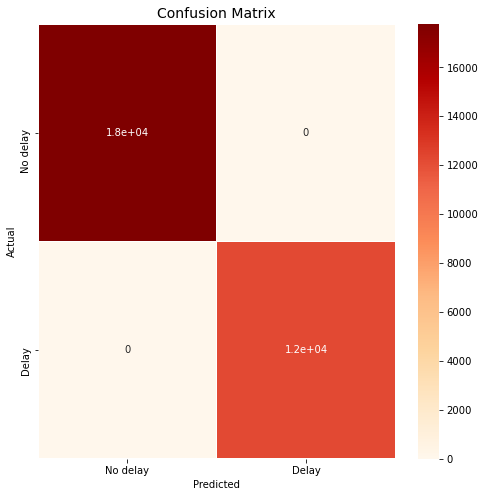

In [20]:
cm = pd.crosstab(y_test, y_pred_test, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(8,8))
sns.heatmap(cm, 
            xticklabels=['No delay', 'Delay'],
            yticklabels=['No delay', 'Delay'],
            annot=True,ax=ax1,
            linewidths=.2, cmap="OrRd")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [21]:
print("[Validation Classification Report:]")
print(classification_report(y_test, y_pred_test))

[Validation Classification Report:]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17770
           1       1.00      1.00      1.00     12230

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



In [ ]:
#use f1-score or roc_auc for imbalanced class
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_test)

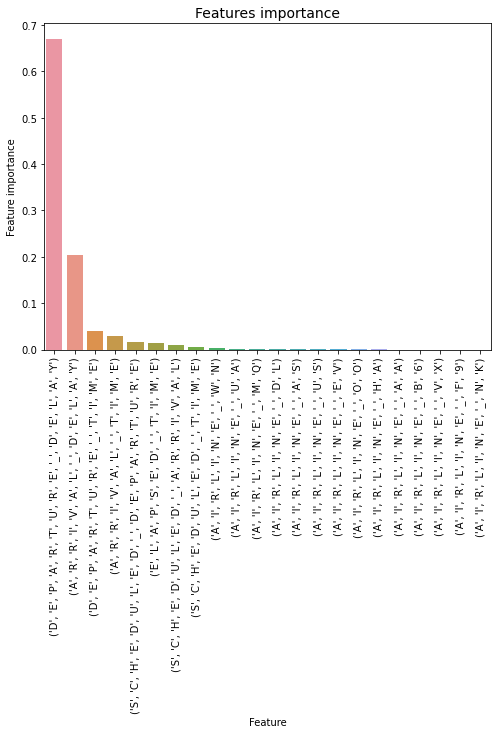

In [27]:
feature_imp = pd.DataFrame({'Feature':X , 'Feature importance': clf.feature_importances_})
feature_imp = feature_imp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (8,6))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=feature_imp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()